# Forelesningsnotat fra 15. februar

I denne økta skal vi se på innlesing, utforskning og enkel modellering av data. 

Vi kommer til å trenge bibliotekene pandas, matplotlib og numpy gjennom økta, så de importerer vi med en gang. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
df = pd.read_csv("https://zenodo.org/record/6075333/files/Boston.csv")
# plot dataframe 

Vi begynner med å se på hvilke kolonner som er i datasettet, for å få oversikt over hva vi jobber med. 

In [29]:
df.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

Det er ikke alltid kolonnenavnene gir så mye mening, men ved å søke litt på nettet kan vi finne ut hva de egentlig betyr: 

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- BLACK - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

For å få oversikt over hvordan verdiene til de forskjellige variablene fordeler seg er det nyttig å lage boxplots:

In [ ]:
for key in df.columns:
    plt.figure()
    df.boxplot(column=[key], figsize=(3,6))

Fra dette lærer vi at noen variable er veldig skjevt fordelt, slik som kriminalitetsrate. De aller fleste områdene har lav kriminalitetsrate, men noen få har veldig høy kriminalitetsrate. Det kan hende vi senere blir nødt til å gjøre en matematisk transformasjon av denne variabelen for å lage en god modell. 

For å få oversikt over relasjonen mellom de ulike variablene kan vi lage en *scatter-matrise*: 

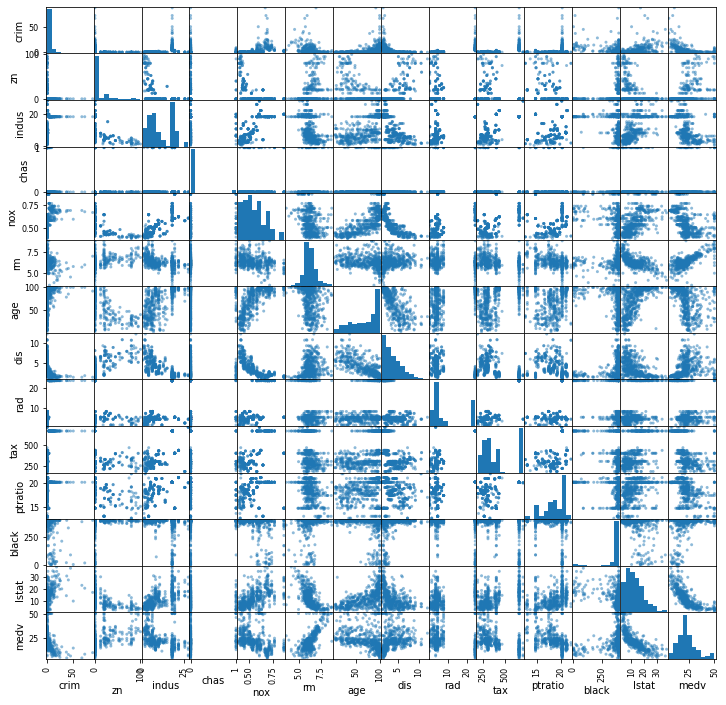

In [30]:
output = pd.plotting.scatter_matrix(df, figsize=(12,12)) # Husk å ta imot output for å unngå masse tekst før plottet

Det kan være litt vanskelig å få oversikt over alle på en gang, siden vinduene blir så små. Derfor kan vi lage oss et nytt dataframe med et mindre utvalg variable, og så lage en scatter-matrise. 

/var/folders/qn/3_cqp_vx25v4w6yrx68654q80000gp/T/ipykernel_51976/2609522147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["crim"] = np.log10(subset["crim"])


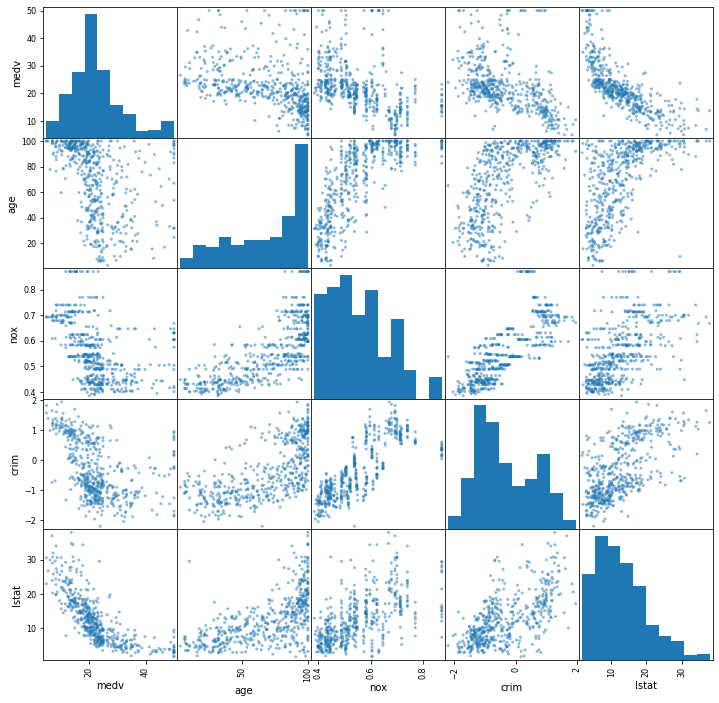

In [33]:
import numpy as np
subset = df[["medv", "age", "nox", "crim", "lstat"]]
subset["crim"] = np.log10(subset["crim"]) # med / uten, vise forskjell
output = pd.plotting.scatter_matrix(subset, figsize=(12, 12))

*(Tilbake til presentasjon)*


# En enkel modell fra boston housing data 
Vi går nå videre til å modellere sammenhengen mellom median boligverdi og NOX-nivå. 

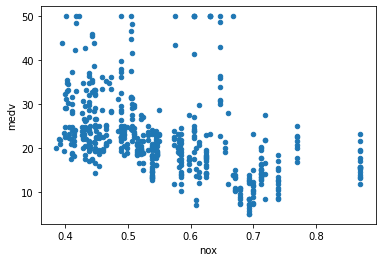

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
df = pd.read_csv("https://zenodo.org/record/6075333/files/Boston.csv")
ax = df.plot("nox", "medv", kind="scatter")

Den første modellen vi skal lage er en der vi i ethvert område velger at estimatet vårt skal være gjennomsnittet av målingene med omtrent samme NOx-nivå. Altså et glidende gjennomsnitt. Dette kan vi gjøre med et par besvergelser i pandas. Ikke bruke mye tid på akkurat hva som foregår, for det er ikke vanlig å lage modeller på denne måten, det er kun for å illustrere. 

In [21]:
window_size = 11
df_sorted = df.sort_values(by="nox")
df_rolled = df_sorted.rolling(window_size, on="nox").mean()

<AxesSubplot:xlabel='nox', ylabel='medv'>

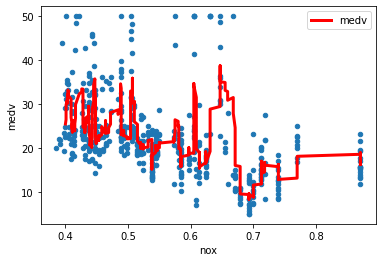

In [26]:

ax = df_sorted.plot("nox", "medv", kind="scatter")
df_rolled.plot("nox", "medv", ax=ax, color="red", linewidth=3)

Er det sannsynlig at dette er den underliggende sammenhengen mellom pris og NOx-forurensing i Boston-området? 

Sannsynligvis er den litt for kaotisk. Vi vil prøve å lage en modell som har strammere regler. En vanlig enkel modell er en lineær modell (**tilbake i obsidian, "noen kommentarer til regresjon"**)


La oss evaluere kvaliteten på denne tilpasningen med $R^2$ score. 

In [36]:
# (Kunne evaliuert R2 for running mean-modellen)
from sklearn.metrics import r2_score
selection = df_rolled["medv"]==df_rolled["medv"]
r2_score(df_sorted["medv"][selection], df_rolled["medv"][selection])

0.41568546815476637

## Lineær regresjon

$\beta_1$:  [-33.91605501]
$\beta_0$:  41.345874467973246
R^2$:  0.18260304250169868


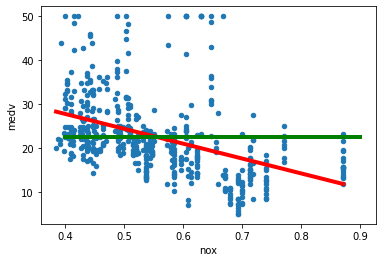

In [53]:
import numpy as np
from sklearn.linear_model import LinearRegression

df = pd.read_csv("https://zenodo.org/record/6075333/files/Boston.csv")
df = df.sort_values(by="nox")

X = df["nox"].values[:,np.newaxis] # Pass på antall klammer
Y = df["medv"].values

linear_model = LinearRegression().fit(X, Y)
print(r"$\beta_1$: ", linear_model.coef_)
print(r"$\beta_0$: ", linear_model.intercept_)
print(r"R^2$: ", linear_model.score(X, Y)) # VENT. Denne scoren ville vært helt krise i fysikk eller kjemi

ax = df.plot("nox", "medv", kind="scatter")
y_hat = linear_model.predict(X)
plt.plot(X, y_hat, color="r", linewidth=4)
plt.plot([0.4, 0.9], [np.average(Y), np.average(Y)], linewidth=4, color="green")

For å illustrere forskjellen mellom den lineære modellen og å bare bruke gjennomsnittet, legger vi inn gjennomsnittet som en grønn strek. $R^2$-scoren sier noe om hvor mye bedre estimat vi gjør ved å bruke modellen vår (rød strek) sammenlignet med bare å gjette på gjennomsnittet. 

Hvilken av modellene er best?

Det kommer an på hvor mye data vi har. Det finnes heldigvis metoder for å teste dette. 

For å ikke gjøre sammenligningen for urettferdig, skal vi glatte ut den første tilpasseren noe, ved å bruke splines. Dette trenger dere ikke å lære dere, jeg bruker det kun for å illustrere.  

## Spline regresjon

R^2:  0.3071772583844179


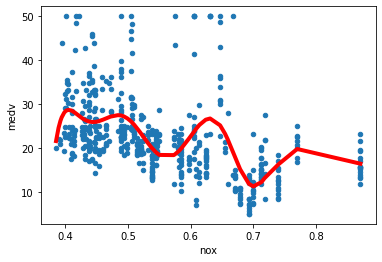

In [9]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

spline_model = make_pipeline(SplineTransformer(n_knots=10, degree=5), Ridge(alpha=1e-5))
spline_model.fit(X, Y)

ax = df.plot("nox", "medv", kind="scatter")
y_hat = spline_model.predict(X)
plt.plot(X, y_hat, color="r", linewidth=4)
# Dropp score slik at studentene får teste dette selv. 
#print("R^2: ", spline_model.score(X, Y)) 

Her har vi beregnet den såkalte $R^2$-scoren. Den forteller hvor mye bedre modellen vår gjør det enn en modell som predikerer gjennomsnittet av dataene våre. 

$R^2$-scoren beregnes ved å sammenligne kvadratet av avstanden mellom datapunktene og modellen vår med kvadratet av avstanden mellom datapunktene og gjennomsnittet av datapunktene, etter følgende formel: 

$$ R^2 = 1 - \frac{\sum_{i=1}^N (y_i - \hat f(x_i))^2}{\sum_{i=1}^N (y_i - \bar{y})^2} $$

der $\hat f(x_i)$ er prediksjonene, $y_i$ er datapunktene og $\bar{y}$ er gjennomsnittet av datapunktene. Dersom vi ikke har laget en fryktelig dårlig modell vil $R^2$-scoren ligge mellom 0 og 1. Verdier nærme 0 indikerer at modellen forklarer lite av variasjonen i dataene, mens verdier nærme 1 indikerer at modellen forklarer mye av variasjonen. 

## Test–Train split
Om vi gjør modellen veldig kompleks, risikerer vi å tilpasse den så mye til treningsdaene at den ikke lenger gir gode estimater på nye data. For å unngå dette kan vi dele opp datasettet vår i treningsdata og testdata. Da tilpasser vi modellen med treningsdata, men så evaluerer vi hvor god modellen er på testdataene, som ikke har blitt brukt i tilpasningen av modellen. 

I kodesnutten under tester vi en rekke forskjellige modeller med økende kompleksitet. Flere *knots* i spline-modellen betyr at modellen kan følge dataene tettere, med økende fare for overtilpasning til treningsdataene. 

In [49]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)#, random_state=83)


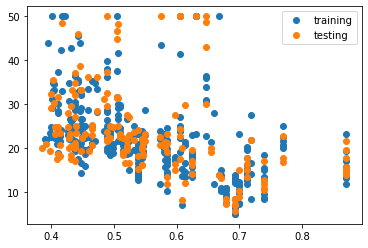

In [51]:
plt.plot(X_train, Y_train, "o", label="training")
plt.plot(X_test, Y_test, "o", label="testing")
plt.legend()

In [54]:
spline_model = make_pipeline(SplineTransformer(n_knots=10, degree=3), Ridge(alpha=1e-5))
spline_model.fit(X_train, Y_train)
train_score = spline_model.score(X_train, Y_train)
test_score = spline_model.score(X_test, Y_test)

print(f"{train_score=}, {test_score=}")


train_score=0.3139672633473338, test_score=0.22922293033446373


(Tilbake til obsidian, underveisoppgave om å sammenligne test-score fra splines og )

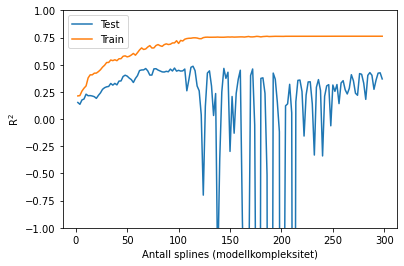

In [11]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=83)

knots = np.arange(2, 300, 2)
test_scores = []
train_scores = []

for n_knots in knots:
    spline_model = make_pipeline(SplineTransformer(n_knots=n_knots, degree=3), Ridge(alpha=1e-5))
    spline_model.fit(X_train, Y_train)
    test_scores.append(spline_model.score(X_test, Y_test))
    train_scores.append(spline_model.score(X_train, Y_train))

plt.plot(knots, test_scores, label="Test")
plt.plot(knots, train_scores, label="Train")
plt.xlabel("Antall splines (modellkompleksitet)")
plt.ylabel(r"R$^2$")
plt.ylim([-1, 1])
plt.legend()

Vi ser av figuren over at modellen gjør det bedre og bedre på testdatasettet inntil vi når et sted mellom 50 og 100 splines. 

## Her slutter forelesningsnotatet
Men under følger det et svært tynt kommentert eksempel for spesielt interesserte. 


## Simulere data
Avsnittet under er for spesielt interesserte. Her simulerer vi et datasett og prøver deretter å lage en modell som skal beskrive datasettet. Fordelen med å gjøre det på denne måten er at vi kan trekke et treningsdatasett og deretter trekke et nytt datasett som vi bruker som testdatasett, fra den samme populasjonen. 

In [16]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

def true_function(x):
    return 8*np.sin(x) + 10*x - 0.07*x**3 + 20
def simulated_data(N):
    x = np.random.random(N)*11
    epsilon = 8
    y = true_function(x) + np.random.randn(N)*epsilon
    df = pd.DataFrame({"tilrettelegging": x, "oppmøte": y})
    return df

def MSE(p, x, y):
    return np.mean((np.polyval(p, x)-y)**2)

N = 300
df = simulated_data(N)
test_df = simulated_data(N)

<AxesSubplot:xlabel='tilrettelegging', ylabel='oppmøte'>

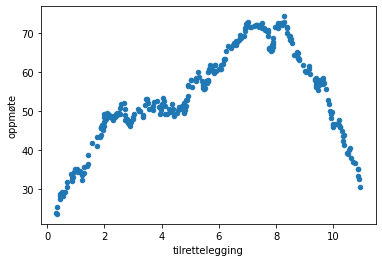

In [17]:
df.sort_values(by="tilrettelegging").rolling(10, on="tilrettelegging").mean().plot("tilrettelegging", "oppmøte", kind="scatter")

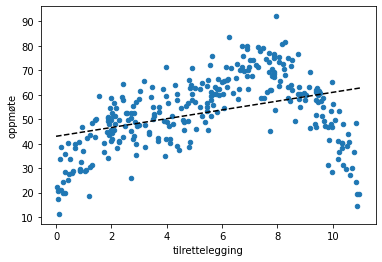

In [18]:
p = np.polyfit(df["tilrettelegging"], df["oppmøte"], 1)

ax = plt.subplot()
df.plot("tilrettelegging", "oppmøte", kind="scatter", ax=ax)
x = np.linspace(0, 11, N)
ax.plot(x, np.polyval(p, x), "--", c="k")
plt.show()

<AxesSubplot:xlabel='tilrettelegging', ylabel='oppmøte'>

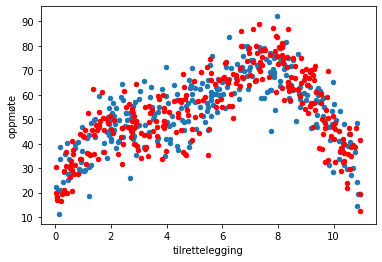

In [19]:
ax = plt.subplot()
#test_df = simulated_data(N)
df.plot("tilrettelegging", "oppmøte", kind="scatter", ax=ax)
test_df.plot("tilrettelegging", "oppmøte", kind="scatter", ax=ax, c="r")

In [20]:
mse = MSE(p, df["tilrettelegging"], df["oppmøte"])
test_mse = MSE(p, test_df["tilrettelegging"], test_df["oppmøte"])

print("MSE train: ", mse)
print("MSE test: ", test_mse)

MSE train:  189.9841236980338
MSE test:  217.7412805225632


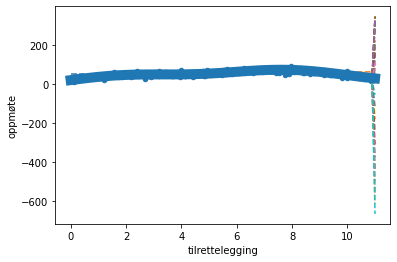

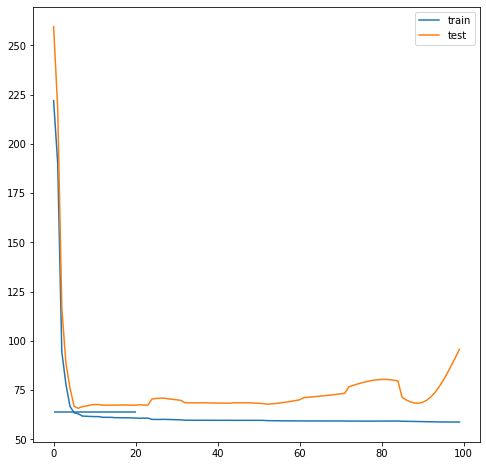

In [21]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)
ax = plt.subplot()
df.plot("tilrettelegging", "oppmøte", kind="scatter", ax=ax)

mse_train = []
mse_test = []

for i in range(100):
    p = np.polyfit(df["tilrettelegging"], df["oppmøte"], i)
    x = np.linspace(0, 11, 100)
    ax.plot(x, np.polyval(p, x), "--")
    mse_train.append(MSE(p, df["tilrettelegging"], df["oppmøte"]))
    mse_test.append(MSE(p, test_df["tilrettelegging"], test_df["oppmøte"]))
    
ax.plot(x, true_function(x), linewidth=10)
plt.show()
plt.figure(figsize=(8,8))
plt.plot(mse_train, label="train")
plt.plot(mse_test, label="test")
plt.hlines(8**2, 0, 20)
plt.legend()